In [1]:
import pandas as pd
import numpy as np
from ultralytics import RTDETR
import torch

import shutil
import os

import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/user/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/user/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/user/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


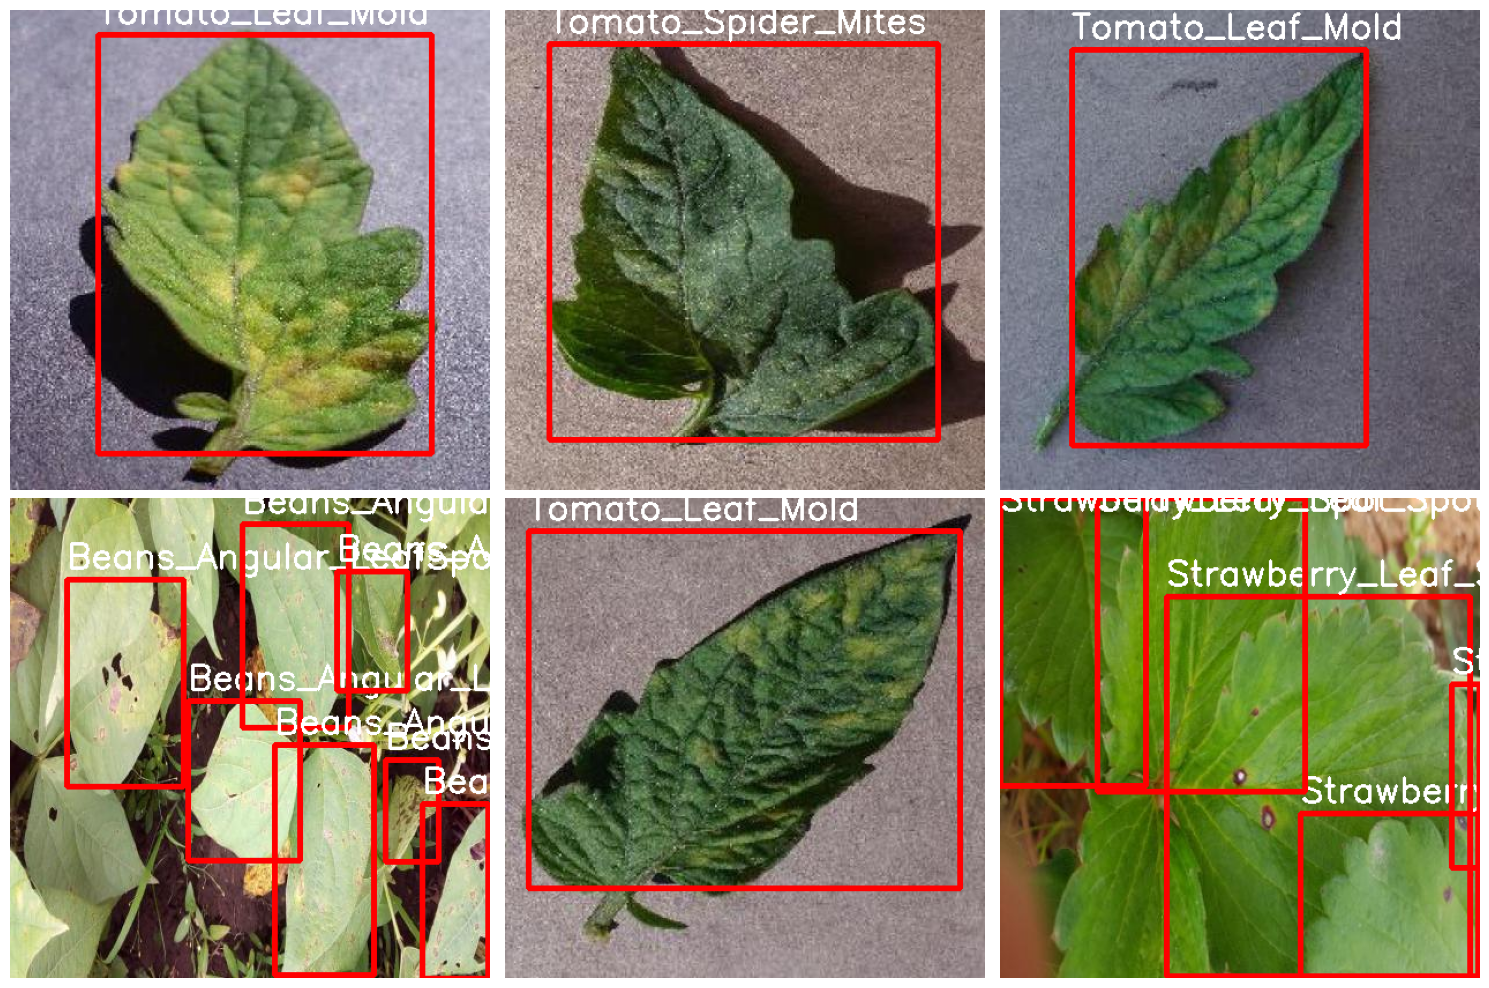

In [2]:
import yaml
random.seed(42)

# Папки с изображениями и метками
images_folder = "/home/user/CourseWork/datasets/Disease/train/images"
labels_folder = "/home/user/CourseWork/datasets/Disease/train/labels"

# Загрузка списка файлов изображений
image_files = os.listdir(images_folder)

# Выбор случайных изображений
random.shuffle(image_files)
random_image_files = image_files[:6]

# Отображение случайных изображений с метками
num_images = len(random_image_files)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()


with open("data.yaml", "r") as f:
    data = yaml.safe_load(f)
classes = data["names"]  # Список классов

for i in range(num_images):
    # Загрузка изображения
    image_file = os.path.join(images_folder, random_image_files[i])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загрузка меток из файла
    label_file = os.path.join(labels_folder, os.path.splitext(random_image_files[i])[0] + ".txt")
    if not os.path.exists(label_file):
        continue
    with open(label_file, "r") as file:
        labels = file.readlines()

    # Отображение изображения с метками
    h, w, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, box_width, box_height = map(float, label.strip().split())

        # Перевод YOLO координат в координаты прямоугольника
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)

        # Настройка уменьшенной толщины и текста
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Толщина = 1
        class_name = classes[int(class_id)] if int(class_id) < len(classes) else f"Class {int(class_id)}"

        font_scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + 10

        # Фон под текстом (для четкости)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Увеличенная толщина
        font_scale = 1.0  # Увеличенный масштаб шрифта
        cv2.putText(image, class_name, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    # Отображение изображения
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [3]:
model = RTDETR("rtdetr-l.pt")

100%|██████████| 63.4M/63.4M [00:08<00:00, 7.86MB/s]


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
model.train(
    data='data.yaml',
    epochs=50,
    imgsz=416,
    optimizer='AdamW',
    lr0=1e-3,
    batch=32,
    device=device,
    project='RT_DETR',
    name='1',
    seed=69
)

New https://pypi.org/project/ultralytics/8.3.112 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=rtdetr-l.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=RT_DETR, name=1, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=69, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning /home/user/CourseWork/Disease/train/labels.cache... 2904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2904/2904 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'



val: Scanning /home/user/CourseWork/Disease/valid/labels.cache... 1416 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1416/1416 [00:00<?, ?it/s]


Plotting labels to RT_DETR/1/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to RT_DETR/1
Starting training for 50 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/50        17G     0.7201        5.4     0.6315         89        416: 100%|██████████| 91/91 [00:49<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]


                   all       1416       3193   0.000466       0.13   0.000823   0.000313

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       2/50      17.2G     0.3463      1.772      0.266         95        416: 100%|██████████| 91/91 [00:47<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.86it/s]


                   all       1416       3193      0.055      0.422     0.0589     0.0389

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       3/50      13.6G     0.3219      1.425     0.2544        108        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.447      0.465      0.348      0.253

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       4/50      17.2G     0.3568      1.011     0.3111        118        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.458      0.504      0.411      0.278

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       5/50      17.3G     0.3553     0.9572     0.3132        123        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.84it/s]


                   all       1416       3193      0.413      0.582      0.455      0.303

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       6/50      15.4G     0.3505     0.9409     0.3055         92        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.85it/s]


                   all       1416       3193      0.553      0.535      0.499      0.354

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       7/50        19G     0.3404     0.9354     0.2976         88        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.606      0.655      0.606      0.445

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       8/50      17.3G     0.3321     0.8596     0.2931         94        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.698      0.631      0.658       0.49

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       9/50      15.4G      0.315     0.8514     0.2827        120        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.643      0.727      0.686      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      10/50      17.2G     0.3112     0.8282     0.2786         82        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.683      0.682      0.676      0.489

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      11/50      17.3G     0.3094     0.8158     0.2743         84        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]


                   all       1416       3193      0.719      0.709      0.696      0.522

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      12/50      17.1G     0.3077     0.7681     0.2713         95        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.719      0.752      0.744      0.566

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      13/50      15.5G     0.3099     0.7696     0.2759         81        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193       0.77      0.675      0.731      0.543

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      14/50      13.5G        0.3     0.7238     0.2687         99        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.748      0.734      0.754       0.58

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      15/50      20.9G     0.2982     0.7117     0.2653        100        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193       0.76      0.809      0.796      0.611

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      16/50      13.5G     0.2922     0.6983     0.2596         96        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]


                   all       1416       3193      0.813      0.772      0.806      0.617

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      17/50      17.2G        0.3     0.6702     0.2583         79        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]


                   all       1416       3193      0.796      0.777      0.799       0.62

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      18/50      15.4G     0.2849      0.666     0.2549        112        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.818        0.8      0.832      0.645

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      19/50      17.3G     0.2842     0.6778     0.2517        131        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.834      0.804      0.832      0.653

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      20/50      18.9G     0.2826     0.6653      0.252        121        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.828      0.799      0.835      0.655

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      21/50      17.3G     0.2815     0.6305     0.2501        113        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.834      0.797      0.848      0.667

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      22/50      17.2G     0.2743     0.6278     0.2446        111        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.845      0.795      0.842      0.662

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      23/50      13.6G     0.2733     0.6423     0.2471         98        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]


                   all       1416       3193       0.81      0.816      0.828      0.648

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      24/50      17.1G     0.2725     0.6009     0.2382         92        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.831      0.824      0.852      0.674

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      25/50      15.5G     0.2684     0.5907     0.2377        138        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]


                   all       1416       3193      0.848      0.836      0.865      0.692

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      26/50      15.4G     0.2631     0.5846     0.2351        115        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193       0.85      0.835       0.87      0.683

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      27/50      19.2G     0.2676     0.5691     0.2364         97        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.847      0.819      0.856      0.681

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      28/50      13.4G     0.2649     0.5698     0.2354         92        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.869      0.826       0.87      0.693

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      29/50      13.6G     0.2575     0.5446     0.2299         83        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.844      0.844      0.873      0.699

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      30/50      15.2G       0.26     0.5491     0.2274        114        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193       0.89      0.825      0.882      0.707

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      31/50      17.1G     0.2581     0.5296     0.2276         90        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]


                   all       1416       3193      0.855       0.85       0.88        0.7

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      32/50      13.5G     0.2564     0.5427     0.2307        109        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]


                   all       1416       3193      0.893      0.837      0.886       0.71

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      33/50      17.3G      0.251     0.5261     0.2192        102        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193       0.88       0.85      0.889      0.719

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      34/50        17G     0.2472     0.5272     0.2216         86        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.879      0.863      0.887      0.718

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      35/50      17.3G     0.2488     0.5112     0.2195         89        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.889      0.849       0.89      0.716

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      36/50      17.2G     0.2438     0.5053      0.216        107        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.902      0.844      0.886      0.719

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      37/50      17.3G     0.2464     0.5154     0.2219         96        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.885      0.852      0.888      0.722

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      38/50      15.4G     0.2393      0.494     0.2131         83        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.84it/s]


                   all       1416       3193      0.879       0.86      0.888      0.718

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      39/50      15.5G     0.2394     0.4781     0.2102        115        416: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.886      0.864      0.891      0.724

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      40/50      18.8G     0.2393     0.4683     0.2075        107        416: 100%|██████████| 91/91 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.889      0.859      0.889      0.724
Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      41/50      13.6G     0.1879     0.4032     0.1932         40        416: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.904      0.852      0.893       0.73

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      42/50      15.4G     0.1893     0.3793     0.1939         53        416: 100%|██████████| 91/91 [00:45<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.892      0.866      0.899      0.731

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      43/50      15.5G     0.1825      0.367     0.1799         53        416: 100%|██████████| 91/91 [00:45<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]


                   all       1416       3193      0.897      0.873      0.905      0.741

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      44/50      15.3G     0.1769     0.3548      0.176         50        416: 100%|██████████| 91/91 [00:45<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.79it/s]


                   all       1416       3193      0.912      0.875      0.911      0.745

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      45/50      13.6G     0.1756      0.351     0.1745         51        416: 100%|██████████| 91/91 [00:45<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.79it/s]


                   all       1416       3193      0.926      0.863      0.908      0.749

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      46/50      15.3G     0.1736     0.3376     0.1723         56        416: 100%|██████████| 91/91 [00:45<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


                   all       1416       3193      0.913      0.881      0.907      0.748

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      47/50      15.5G     0.1733     0.3335     0.1711         57        416: 100%|██████████| 91/91 [00:45<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.919      0.865      0.906       0.75

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      48/50      15.4G     0.1693     0.3277     0.1673         46        416: 100%|██████████| 91/91 [00:45<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193       0.91       0.88      0.909      0.749

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      49/50      19.2G     0.1661     0.3147     0.1632         52        416: 100%|██████████| 91/91 [00:45<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]


                   all       1416       3193      0.917      0.883      0.909       0.75

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/91 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      50/50      13.5G     0.1691     0.3129     0.1666         51        416: 100%|██████████| 91/91 [00:45<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


                   all       1416       3193      0.918      0.877      0.909      0.748

50 epochs completed in 0.792 hours.
Optimizer stripped from RT_DETR/1/weights/last.pt, 66.2MB
Optimizer stripped from RT_DETR/1/weights/best.pt, 66.2MB

Validating RT_DETR/1/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
rt-detr-l summary: 302 layers, 32,008,400 parameters, 0 gradients, 103.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.07it/s]


                   all       1416       3193      0.917      0.883      0.909       0.75
Beans_Angular_LeafSpot         83        277      0.752      0.669      0.666       0.43
            Beans_Rust         97        463      0.824      0.809      0.858      0.615
Strawberry_Angular_LeafSpot        166        193      0.978      0.909      0.954      0.784
Strawberry_Anthracnose_Fruit_Rot         47         85      0.975      0.928      0.958      0.684
Strawberry_Blossom_Blight        104        161      0.991      0.981      0.995      0.906
  Strawberry_Gray_Mold        192        200      0.886      0.895      0.914      0.653
  Strawberry_Leaf_Spot        199        779      0.869      0.878      0.912      0.814
Strawberry_Powdery_Mildew_Fruit         77        151      0.917       0.73      0.835      0.652
Strawberry_Powdery_Mildew_Leaf        155        584      0.827      0.801      0.848       0.73
         Tomato_Blight        100        100      0.985       0.99      0.9

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fd522e80d60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,  

In [6]:
df = pd.read_csv('RT_DETR/1/results.csv')

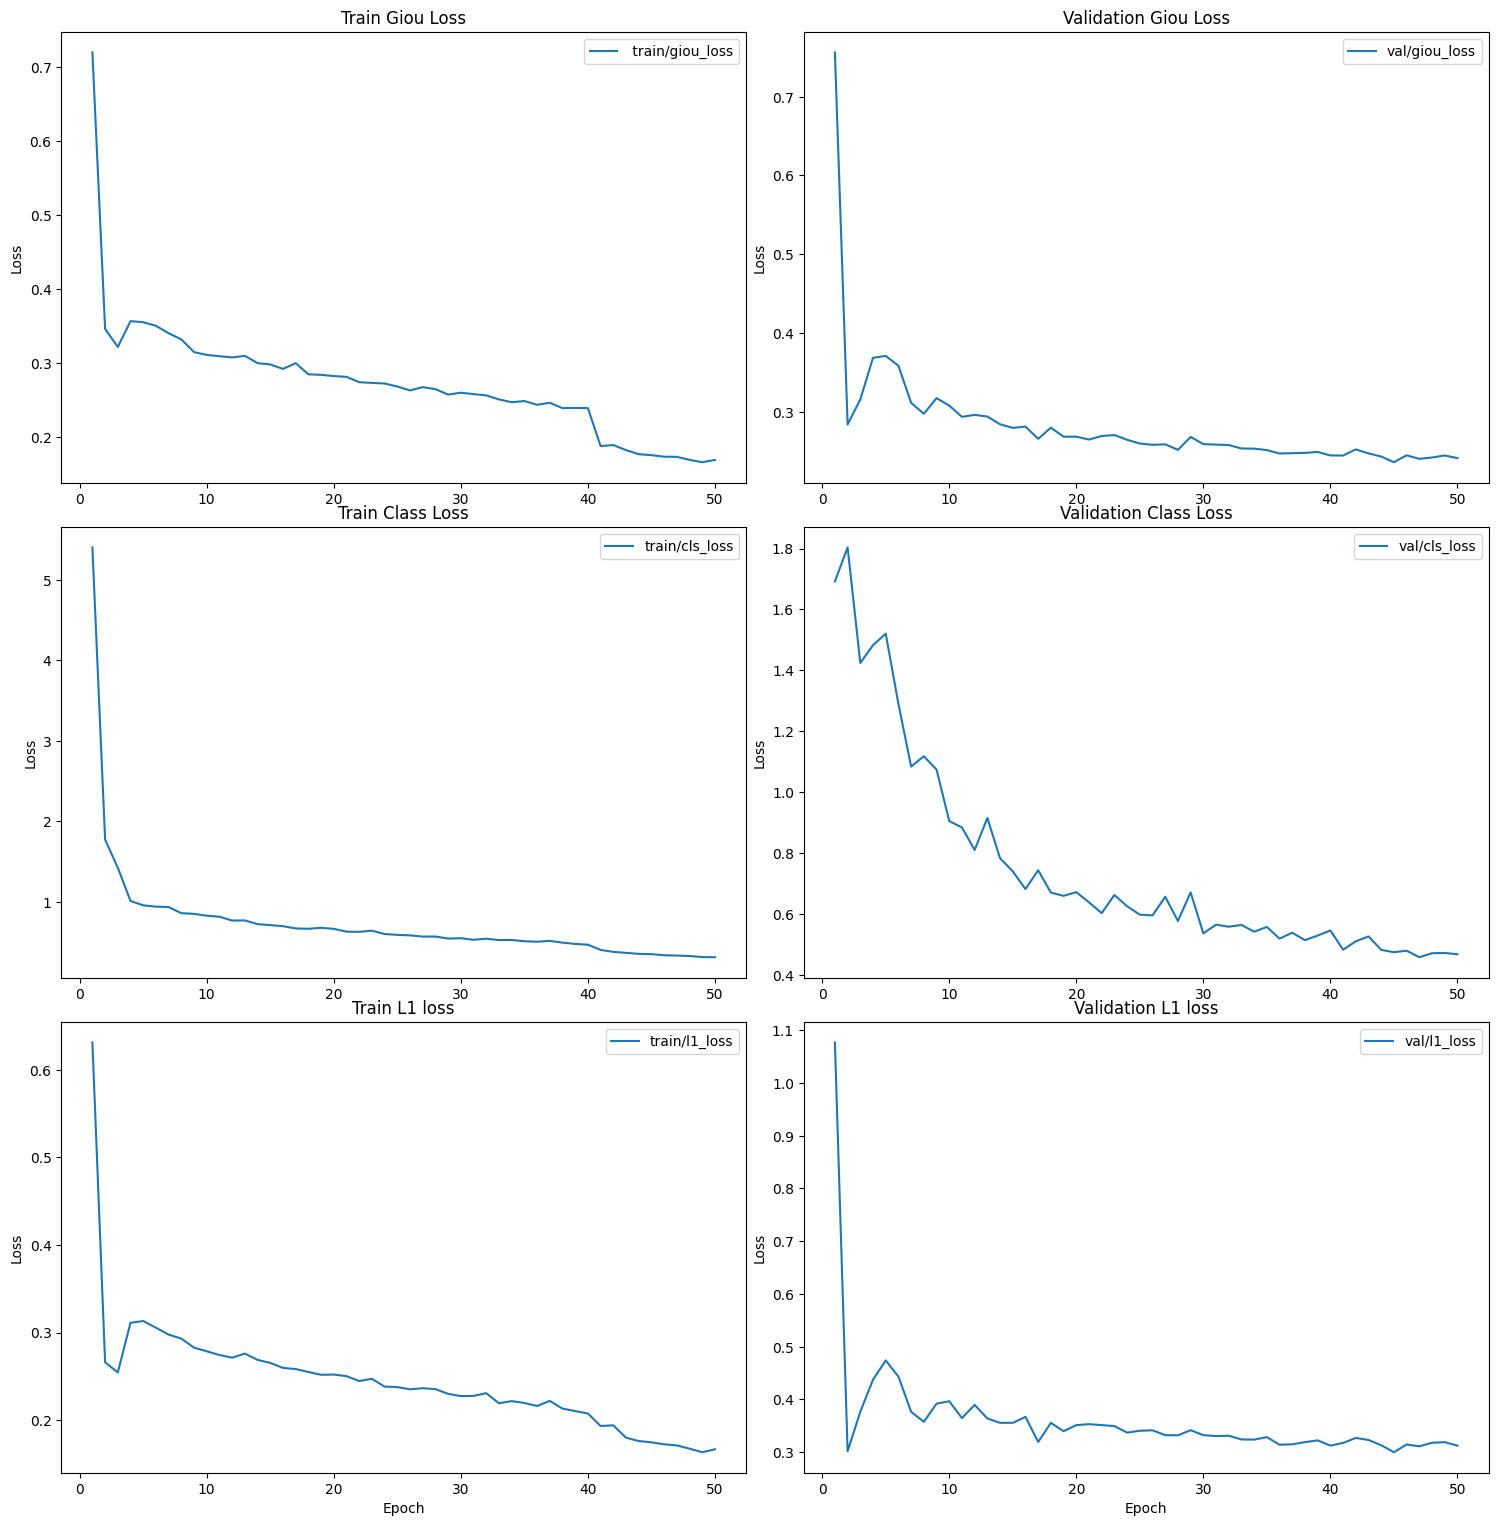

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

# train/box_loss
axes[0, 0].plot(df['epoch'], df['train/giou_loss'], label=' train/giou_loss')
axes[0, 0].set_title('Train Giou Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# val/box_loss
axes[0, 1].plot(df['epoch'], df['val/giou_loss'], label='val/giou_loss')
axes[0, 1].set_title('Validation Giou Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# train/cls_loss
axes[1, 0].plot(df['epoch'], df['train/cls_loss'], label='train/cls_loss')
axes[1, 0].set_title('Train Class Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# val/cls_loss
axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='val/cls_loss')
axes[1, 1].set_title('Validation Class Loss')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# train/dfl_loss
axes[2, 0].plot(df['epoch'], df['train/l1_loss'], label='train/l1_loss')
axes[2, 0].set_title('Train L1 loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()

# val/dfl_loss
axes[2, 1].plot(df['epoch'], df['val/l1_loss'], label='val/l1_loss')
axes[2, 1].set_title('Validation L1 loss')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()

plt.show()

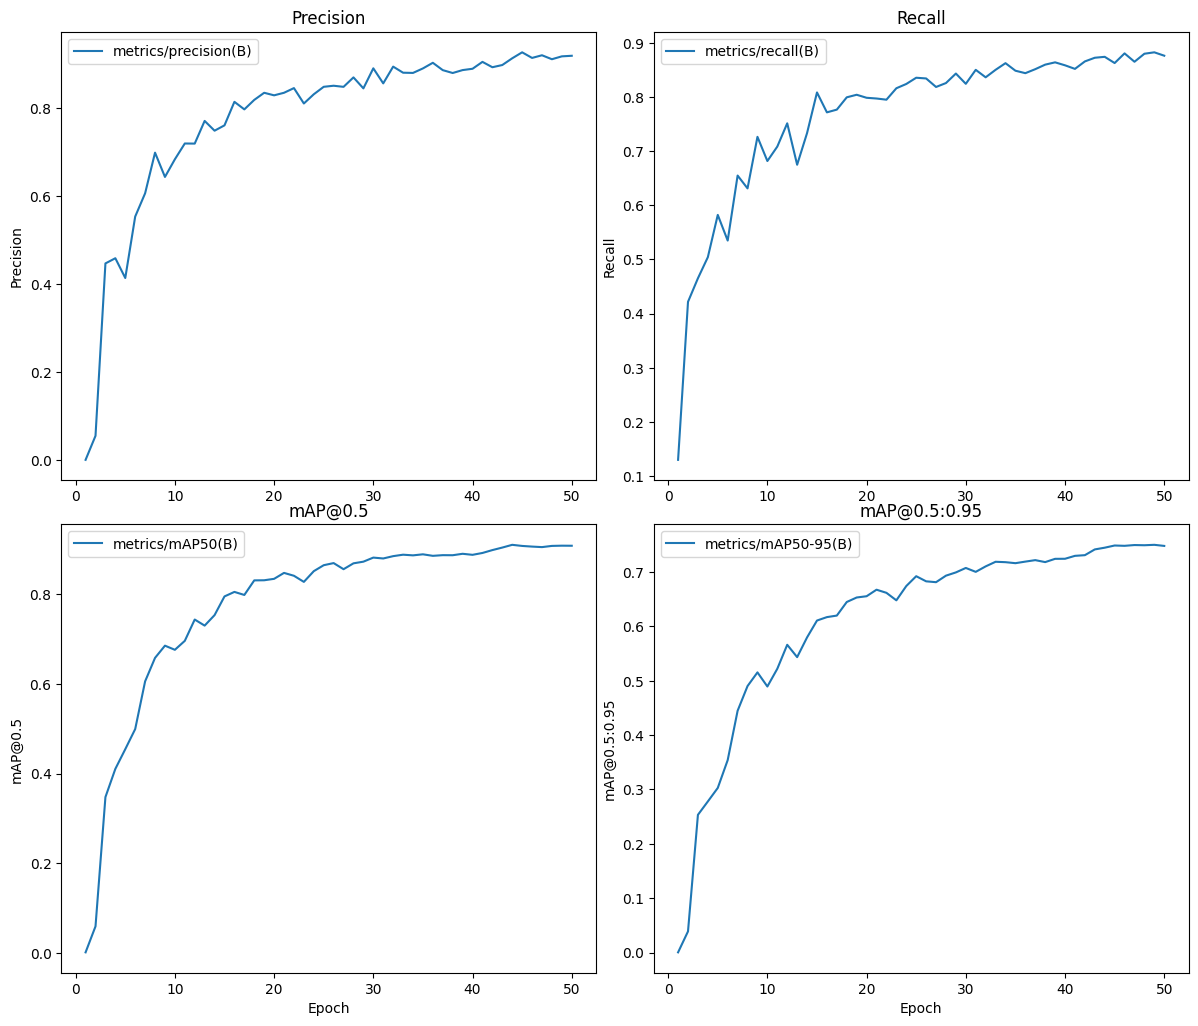

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout()

# metrics/precision(B)
axes[0, 0].plot(df['epoch'], df['metrics/precision(B)'], label='metrics/precision(B)')
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].legend()

# metrics/recall(B)
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], label='metrics/recall(B)')
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].legend()

# График для metrics/mAP50(B)
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='metrics/mAP50(B)')
axes[1, 0].set_title('mAP@0.5')
axes[1, 0].set_ylabel('mAP@0.5')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# metrics/mAP50-95(B)
axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='metrics/mAP50-95(B)')
axes[1, 1].set_title('mAP@0.5:0.95')
axes[1, 1].set_ylabel('mAP@0.5:0.95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.show()


image 1/1 /home/user/CourseWork/Disease/test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg: 416x416 6 Beans_Angular_LeafSpots, 35.8ms
Speed: 0.7ms preprocess, 35.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


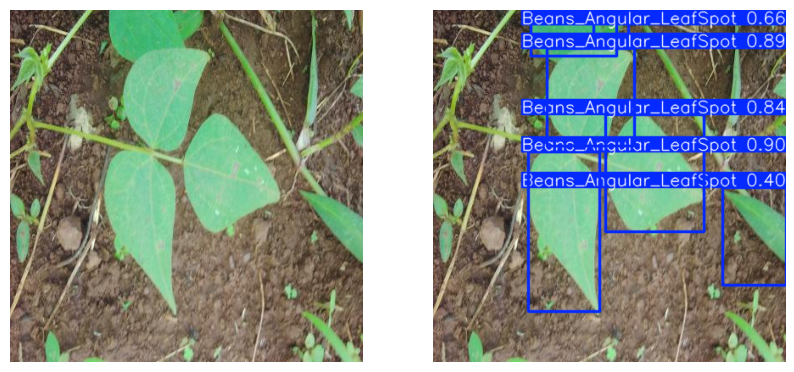

In [11]:
res = model('test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg')
detect_img = res[0].plot()
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Отображение первого изображения
axes[0].imshow(plt.imread('test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg'))
axes[0].axis('off')

# Отображение результатов модели
axes[1].imshow(detect_img)
axes[1].axis('off')

plt.show();